In [45]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import h5py
import pandas as pd
import numpy as np
import copy
import os
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [1]:
# daa = load_data('2018092_20180930')
# format1_path = 'data_format1_' + '20181007_20181014' + '.h5'
# f1_data = pd.HDFStore(os.path.join(data_root, format1_path))


auxiliary.py         model_lstm_reg.ipynb strategy.py
backTest.ipynb       models


In [46]:
data_root = '../../data/'
root = './'
model_folder = './models/'
report_folder = './report_rc/'

In [47]:
'''
format1: {currency_type: {time: ['close', 'high', 'low', 'open', 'volume']}}
format2: {time: {currency_type: ['close', 'high', 'low', 'open', 'volume']}}
'''

def load_data(date_list):
    data_root = '../../data/'
    currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    curr_info = dict.fromkeys(currencies)
    
    date_list = date_list if type(date_list) is list else [date_list]
    
    for date in date_list:
        print(f'load data from {date}')
        format1_path = 'data_format1_' + date + '.h5'
        f1_data = pd.HDFStore(os.path.join(data_root, format1_path))

        for curr in currencies:
            if curr_info[curr] is None:
                curr_info[curr] = f1_data[curr]
            else:
                curr_info[curr] = curr_info[curr].append(f1_data[curr])
        f1_data.close()
        
    for key, item in curr_info.items():
        curr_info[key]['volume_minmax'] = MinMaxScaler().fit_transform(item[['volume']]).reshape(1,-1)[0]        
        curr_info[key]['avg'] = item[['close', 'high', 'low', 'open']].mean(axis=1)
        
    return curr_info # {curr_name: cur_df}

def load_h5(date):
    data_root = './drive/Colab Notebooks/data/'
    format1_path = 'data_format1_' + date + '.h5'
    format2_path = 'data_format2_' + date + '.h5'
    
    f1_data = h5py.File(os.path.join(data_root, format1_path), 'r')
    f2_data = h5py.File(os.path.join(data_root, format2_path), 'r')
    
    return f1_data, f2_data
    

In [6]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
data['BCH-USD'].head()

,close,high,low,open,volume,volume_minmax,avg
time,,,,,,,
2018-09-01 06:00:00,550.97,550.97,550.97,550.97,1.839054,0.000979,550.970
2018-09-01 06:01:00,550.97,550.97,550.97,550.97,0.000000,0.000000,550.970
2018-09-01 06:02:00,550.97,550.97,550.97,550.97,0.000000,0.000000,550.970
2018-09-01 06:03:00,550.96,550.97,550.96,550.97,0.086600,0.000046,550.965
2018-09-01 06:04:00,550.97,550.97,550.96,550.96,7.050036,0.003754,550.965


In [13]:
date_list = ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808',
             '20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
             '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
             '20181028_20181104', '20181104_20181111']
# date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
#              '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
#              '20181028_20181104', '20181104_20181111']

data = load_data(date_list)

load data from 201801
load data from 201802
load data from 201803
load data from 201804
load data from 201805
load data from 201806
load data from 201807
load data from 201808
load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111


In [ ]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

for curr in currencies:
    data[curr] = data[curr].reset_index()
    data[curr] = data[curr].drop_duplicates(subset='time', keep='first')
    data[curr] = data[curr].set_index('time')

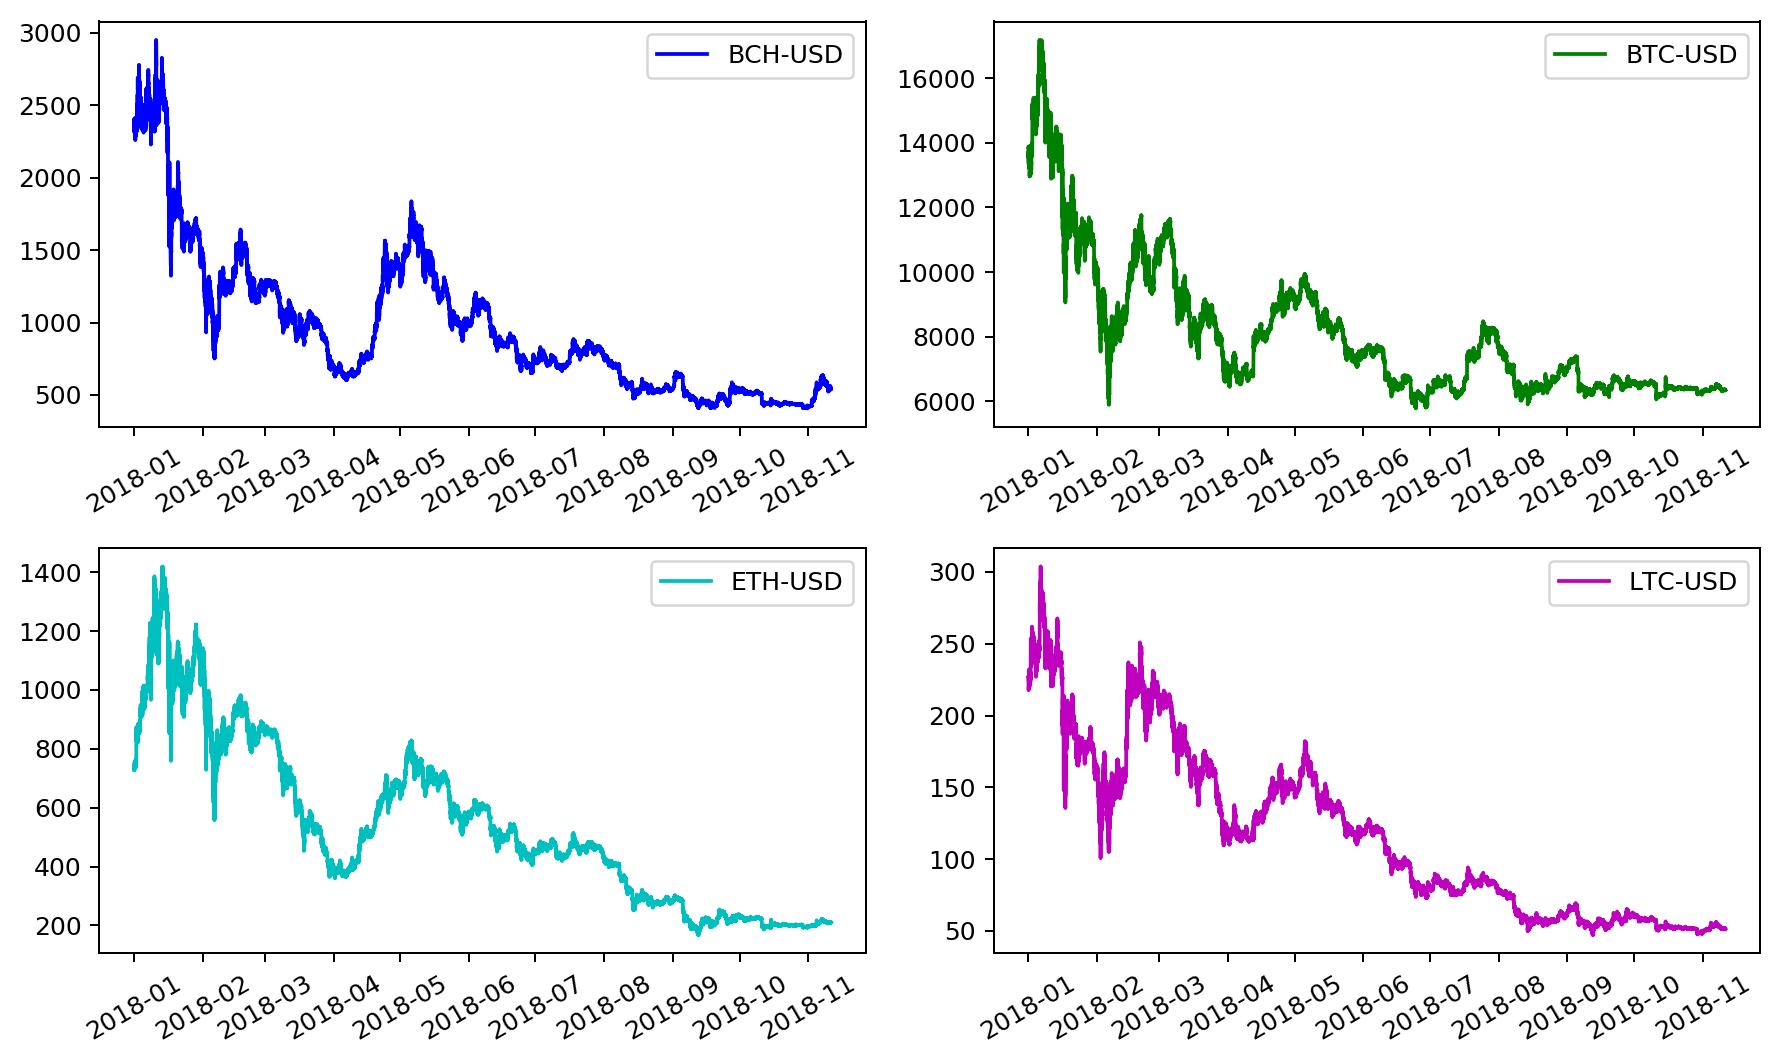

In [33]:
plt.figure(figsize=(10, 6), dpi=180)
colors = ['b', 'g', 'c', 'm']
for i in range(4):
    curr = currencies[i]
    color = colors[i]
    plt.subplot(2,2,i+1)
    plt.plot(data[curr].index, data[curr][['avg']], color, label=curr)
    plt.axis('tight')
    plt.legend()
    plt.xticks(rotation=60)
    
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'Average_Prices_of_Currencies_1801_1812.jpg'))
plt.show()

## Modeling

In [48]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, Flatten

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split 

In [49]:
# !pip3 install tensorflow-gpu

In [99]:
def build_model(dims_per_layer):
    loss_func = 'mse'
    optimiser_func = 'rmsprop' # rmsprop
    activation_func = 'selu'  # linear
    
    rnn_model = Sequential()

    # Plan A
    rnn_model.add(LSTM(
                input_dim=dims_per_layer[0],
                output_dim=64,
                return_sequences=True, 
                activation=activation_func))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(LSTM(128, return_sequences=False, activation=activation_func))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(Dense(output_dim=1))
    rnn_model.add(Activation(activation_func))
 
    rnn_model.compile(loss=loss_func, optimizer=optimiser_func)
    return rnn_model

def train_model(model_name, train_x, train_y, test_x, test_y, epoches=100, batch_size=4):
    
    model = build_model([train_x.shape[-1], 128, 64, 1])
    history = model.fit(train_x, train_y, epochs=epoches, batch_size=batch_size, validation_data=(test_x, test_y), verbose=2, shuffle=False)

    model.save(os.path.join(model_folder, f'./{model_name}.h5'))
    return model, history
    

def split_train_xy(df, window_x, window_y, stride=1):
    train_x = []
    train_y = []
    i = 0
    while(i+window_x+window_y < len(df)):
        train_x = train_x.append((df[i:(i+window_x)][['open', 'close', 'high', 'low', 'volume_minmax']]).values)
#         train_y.append(df[(i+window_x):(i+window_x+window_y)][['avg']])
        train_y = train_y.append((df.iloc[(i+window_x+window_y)][['avg']]).values)
        
        i += stride
                
    return train_x, train_y


In [92]:
# build model & prepare train test data set
def create_dataset(dataset, look_back=1, look_forward=1):
    data_x = []
    data_y = [] # value changed of next look_forward duration
    i = 0
    while i < len(dataset)-look_back-look_forward-1:
        x = dataset[i:(i+look_back), 0]
        data_x.append(x)
#         y = dataset[i+look_back+look_forward, 0] - dataset[i+look_back, 0]
        y = dataset[i+look_back+look_forward, 0]
#         y = dataset[i+look_back, 0]
        data_y.append(y)
        i += look_forward
        
    return np.array(data_x), np.array(data_y)

In [95]:
## Increasing Window size

# date_list = ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808',
#              '20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
#              '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
#              '20181028_20181104', '20181104_20181111']
date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
             '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
             '20181028_20181104', '20181104_20181111']

data = load_data(date_list)

data_test = load_data('20181111_20181118')


load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111
load data from 20181111_20181118


BCH-USD data processing
(1701, 1, 120)
BCH-USD model training
Train on 1701 samples, validate on 165 samples
Epoch 1/60
 - 21s - loss: 35598.2576 - val_loss: 5667.6287
Epoch 2/60
 - 12s - loss: 6756.3318 - val_loss: 8811.2502
Epoch 3/60
 - 14s - loss: 6776.0952 - val_loss: 14332.7721
Epoch 4/60
 - 13s - loss: 8052.3385 - val_loss: 9158.2160
Epoch 5/60
 - 12s - loss: 7410.0486 - val_loss: 9633.5930
Epoch 6/60
 - 13s - loss: 5890.6071 - val_loss: 7224.4566
Epoch 7/60
 - 12s - loss: 7261.0793 - val_loss: 6602.7221
Epoch 8/60
 - 12s - loss: 6817.8328 - val_loss: 11170.2897
Epoch 9/60
 - 11s - loss: 6460.9451 - val_loss: 7260.7776
Epoch 10/60
 - 13s - loss: 6207.9010 - val_loss: 9669.1668
Epoch 11/60
 - 12s - loss: 6251.5011 - val_loss: 6770.6269
Epoch 12/60
 - 12s - loss: 6125.5756 - val_loss: 14121.2278
Epoch 13/60
 - 12s - loss: 6308.8655 - val_loss: 1704.7806
Epoch 14/60
 - 11s - loss: 5508.7769 - val_loss: 10599.0612
Epoch 15/60
 - 11s - loss: 5336.0138 - val_loss: 972.4931
Epoch 16/60

Epoch 32/40
 - 14s - loss: 519.8316 - val_loss: 636.3210
Epoch 33/40
 - 14s - loss: 492.8078 - val_loss: 878.9272
Epoch 34/40
 - 14s - loss: 532.0459 - val_loss: 142.3918
Epoch 35/40
 - 16s - loss: 510.3335 - val_loss: 605.3173
Epoch 36/40
 - 14s - loss: 497.8820 - val_loss: 895.9175
Epoch 37/40
 - 13s - loss: 478.9027 - val_loss: 285.3693
Epoch 38/40
 - 17s - loss: 542.2105 - val_loss: 100.5199
Epoch 39/40
 - 13s - loss: 494.0984 - val_loss: 308.4161
Epoch 40/40
 - 13s - loss: 483.6082 - val_loss: 973.6398
LTC-USD data processing
(1701, 1, 120)
LTC-USD model training
Train on 1701 samples, validate on 165 samples
Epoch 1/20
 - 27s - loss: 148.8703 - val_loss: 188.9626
Epoch 2/20
 - 14s - loss: 61.0222 - val_loss: 1.2970
Epoch 3/20
 - 12s - loss: 50.2058 - val_loss: 13.0366
Epoch 4/20
 - 12s - loss: 40.4677 - val_loss: 22.4170
Epoch 5/20
 - 14s - loss: 33.6750 - val_loss: 48.4639
Epoch 6/20
 - 14s - loss: 31.9640 - val_loss: 7.3276
Epoch 7/20
 - 13s - loss: 26.7442 - val_loss: 24.3961


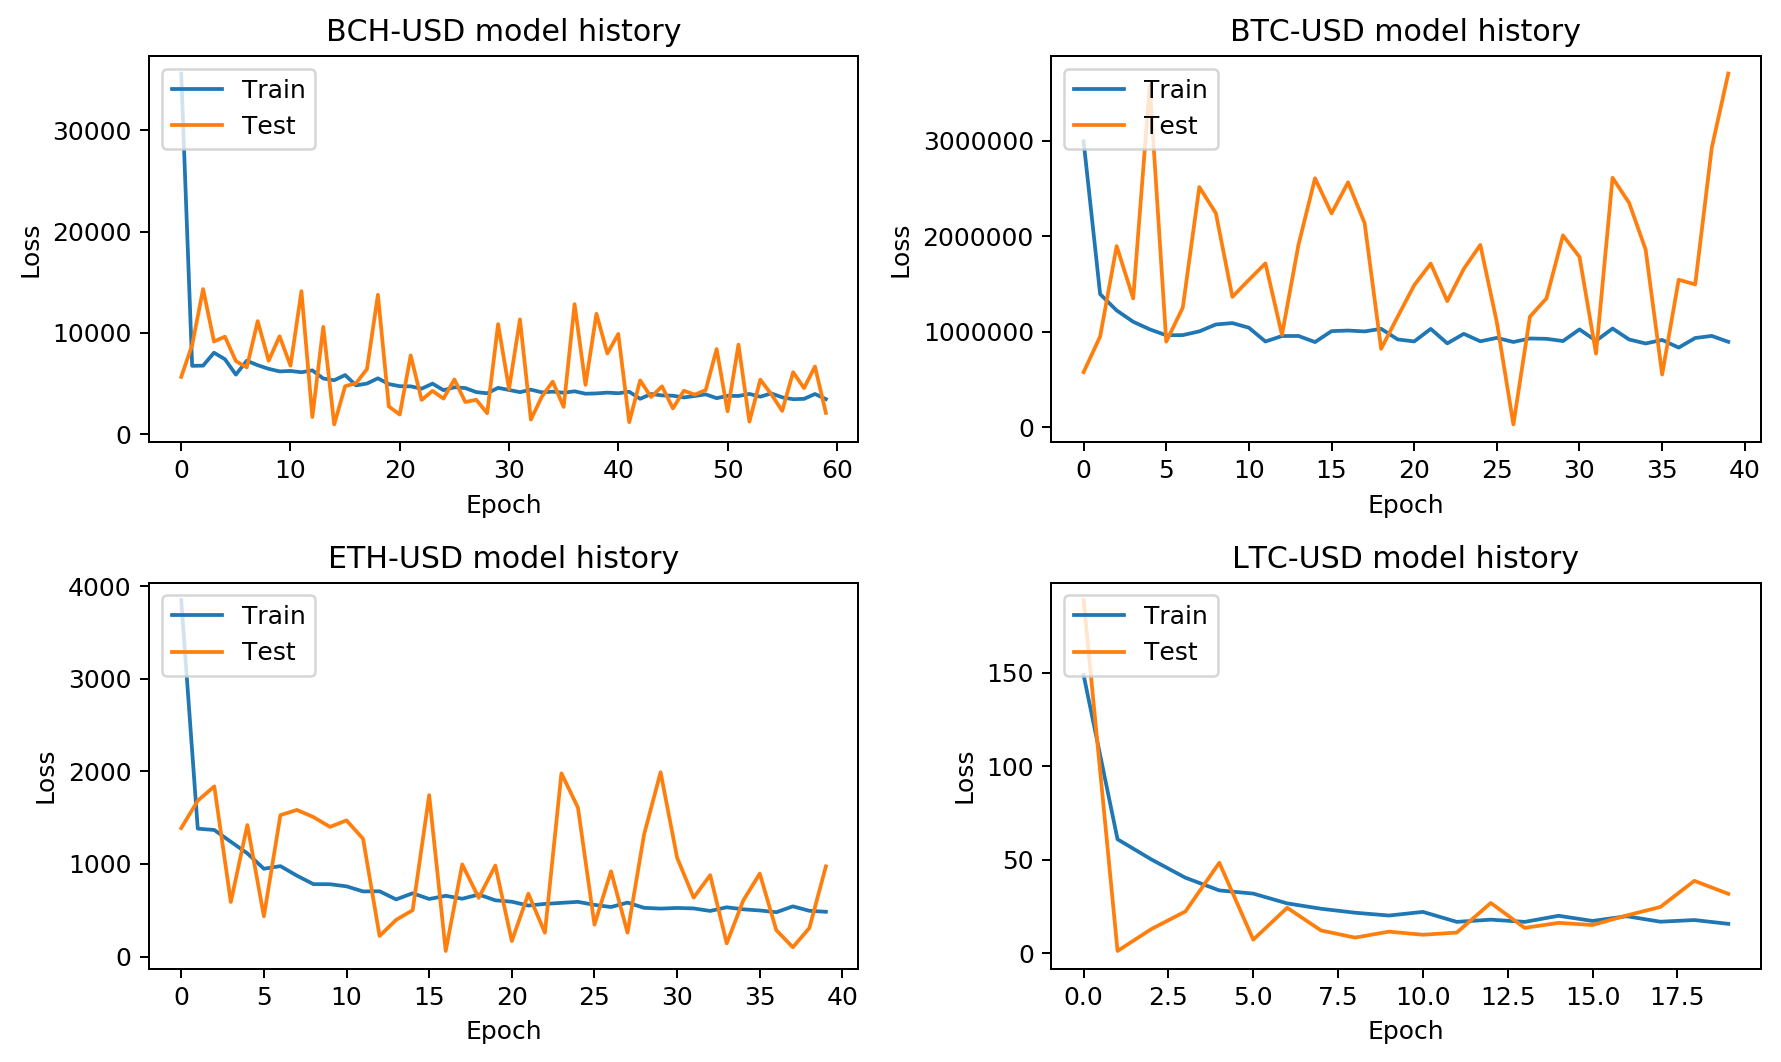

In [102]:
time_unit = 60
look_back = time_unit * 2
look_forward = time_unit * 1

models = {}
history = {}
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
epoch = [60, 40, 40, 20]

count = 0
plt.figure(figsize=(10, 6), dpi=180)

for curr in currencies:
    
    print(f'{curr} data processing')
    data_curr = data[curr][['avg']]
    test = data_test[curr][['avg']]
  
    train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
    test_x, test_y = create_dataset(test.values, look_back, look_forward)
    
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    print(train_x.shape)
    
    print(f'{curr} model training')
    model_curr, history = train_model(f'lstm_{curr}_model_selu', train_x, train_y, test_x, test_y, epoches=epoch[count])
    models[curr] = model_curr
    
    count += 1
    plt.subplot(2, 2, count)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{curr} model history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
plt.tight_layout()
plt.savefig('./model_history_1809_1812_1h.png')
plt.show()

In [69]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [75]:
# SVG(model_to_dot(models['BCH-USD']).create(prog='dot', format='svg'))

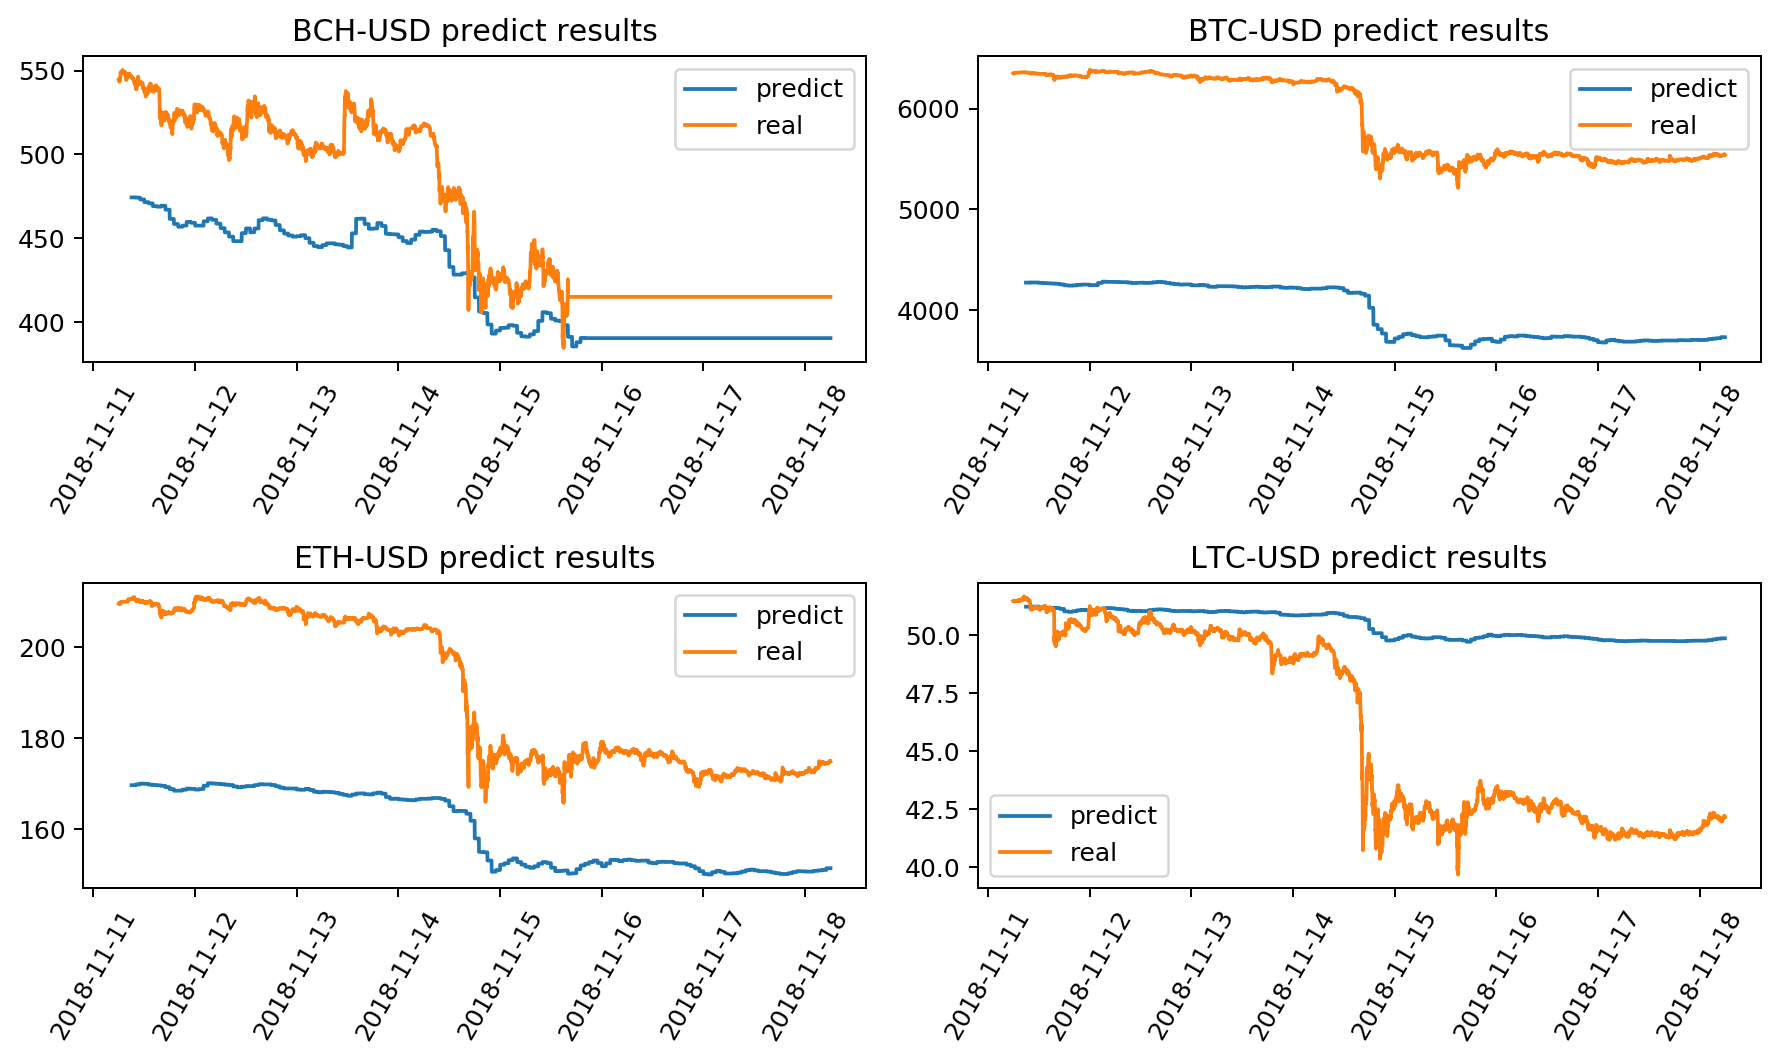

In [103]:
plt.figure(figsize=(10, 6), dpi=180)
for i in range(4):
    curr = currencies[i]
    asset_df = data_test[curr][['avg']]
    test_x, _ = create_dataset(asset_df.values, look_back, look_forward)
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    y = models[curr].predict(test_x)
    
    count = 0
    list_y = np.array([])
    while count < len(asset_df):
        index = int(count/look_forward) - 3
        if index < 0:
            list_y = np.append(list_y, np.nan)
        else:
            list_y = np.append(list_y, y[index])
        count+=1
    
    asset_df['predict'] = list_y
    
    plt.subplot(2,2,i+1)
    plt.plot(asset_df.index, asset_df['predict'], label='predict')
    plt.plot(asset_df.index, asset_df['avg'], label='real')
    plt.xticks(rotation=60)
    plt.title(f'{curr} predict results')
    plt.legend()
    
plt.tight_layout()
plt.savefig('./lstm_1h_1118_v2.png')
plt.show()

In [21]:
from keras.utils import plot_model

AttributeError: 'dict' object has no attribute 'history'

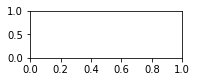

In [28]:
count = 1
plt.figsize()
for i in currencies:
#     plot_model(models[curr], f'{i}_model.png')
    plt.subplot(4, 2, count)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{i} Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(4, 2, count+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{i} Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    count+=2
    
plt.show()

In [26]:
!pip install pydot


  Using cached https://files.pythonhosted.org/packages/50/da/68cee64ad379462abb743ffb665fa34b214df85d263565ad2bd512c2d935/pydot-1.3.0-py2.py3-none-any.whl


load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111


In [26]:
li = []
for i in currencies:
    li.append(joblib.load(os.path.join(root, f'model_{curr.lower()}.joblib')))

FileNotFoundError: [Errno 2] No such file or directory: './model_bch-usd.joblib'

In [27]:
i = 0
for m in li:
    m.save(os.path.join(root, f'model_{currencies[i].lower()}.h5'))
    i+=1

In [11]:
m = build_model([120])
m.load_weights(os.path.join(model_folder, 'model_bch_weight.h5'))

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [17]:
import keras
print(keras.__version__)

2.2.4
